# chapter 5 - the many variables and spurious waffles

Switching from pymc to numpyro here - I tried some personal experiments and found out i really dislike pytensor - it's hard to debug. And jax is great


In [190]:
import arviz as az
import graphviz
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive


A confound misleads us about causal influence. They can hide important effects as well as mislead with false effects.


In [130]:
df = pd.read_csv("./data/WaffleDivorce.csv", sep=";")
df.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


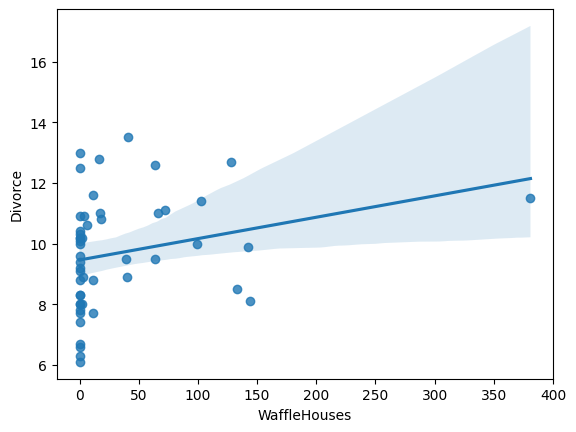

In [131]:
sns.regplot(df, x="WaffleHouses", y="Divorce");

In [132]:
# bayesian link just to warm up with numpyro
def waffle_divorce_linear(X=None, y=None):
    alpha = numpyro.sample("alpha", dist.Normal(10, 10))
    beta = numpyro.sample("beta", dist.Normal(0, 5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = alpha + beta * X
    numpyro.sample("divorce", dist.Normal(mu, sigma), obs=y)


X = df["WaffleHouses"].values
y = df["Divorce"].values


mcmc = MCMC(NUTS(waffle_divorce_linear), num_warmup=100, num_samples=1000)
mcmc.run(random.PRNGKey(0), X, y)

sample: 100%|██████████| 1100/1100 [00:01<00:00, 1039.97it/s, 7 steps of size 7.24e-02. acc. prob=0.94]


In [133]:
posterior = mcmc.get_samples()
posterior_az = az.from_numpyro(mcmc)

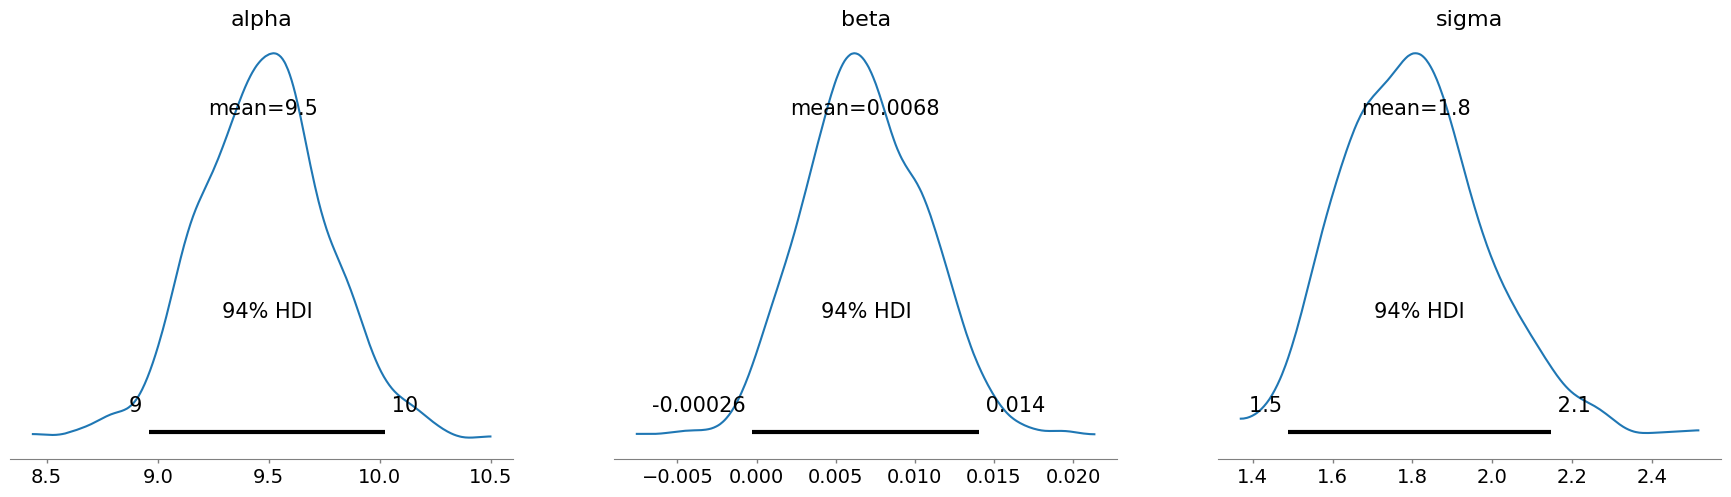

In [134]:
az.plot_posterior(posterior_az);

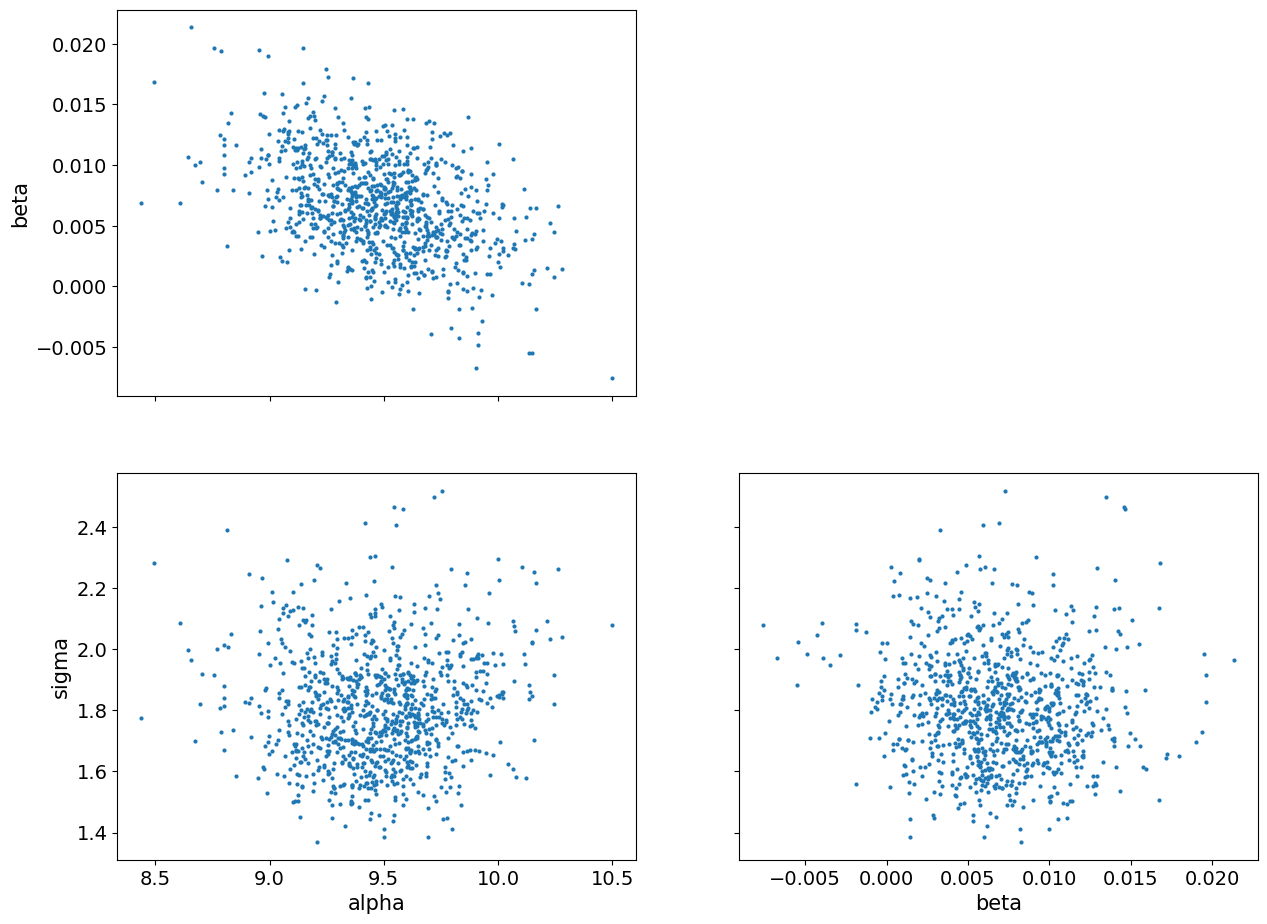

In [135]:
az.plot_pair(posterior_az, var_names=["alpha", "beta", "sigma"]);

> let's learn numpy array broadcasting, which will make life simpler calculating mu_dist

We have a range of input values `X`, and we want a distrubution of mu for each. The shape should be (num_data_points, 1000) [assuming 1000 points were sampled].

In broadcasting, numpy compares the rightmost direction and works its way left. The individual dimensions should either be the same _or one of them can be 1_. When either of the dimensions compared is one, the other is used.

if i have arrays of size 50 and 1000,

```
# aligning rightmost onwards
# incompatible!
  50
1000

# compatible
    50
1000 1
=> 1000,50

50, 1
    1000
=> 50, 1000
```


In [136]:
a = np.array([1, 2])
b = np.array([-1, -2, -3])

# this None thing adds an axis
print((b[:, None] * a).shape)
print(b.shape)
(b[:, None] * a) + b[:, None]

(3, 2)
(3,)


array([[-2, -3],
       [-4, -6],
       [-6, -9]])

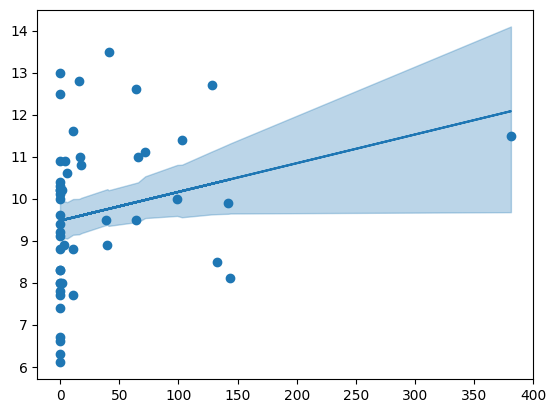

In [137]:
# plot mean and mean pi

# array broadcasting to get distribution for each input sample
# the shape of mu_hat here is (num_mcmc_samples, num_inp_samples)
mu_hat = posterior["alpha"][:, None] + posterior["beta"][:, None] * X
hdpi = numpyro.diagnostics.hpdi(mu_hat, prob=0.89, axis=0)

# plotting
plt.scatter(X, y)
plt.plot(X, np.mean(mu_hat, axis=0), c="C0")
sort_idx = jnp.argsort(X)
plt.fill_between(
    X[sort_idx], hdpi[0][sort_idx], hdpi[1][sort_idx], alpha=0.3, color="C0"
)

> sidequest of playing with numpyro complete ! moving on...


<Axes: xlabel='Marriage', ylabel='Divorce'>

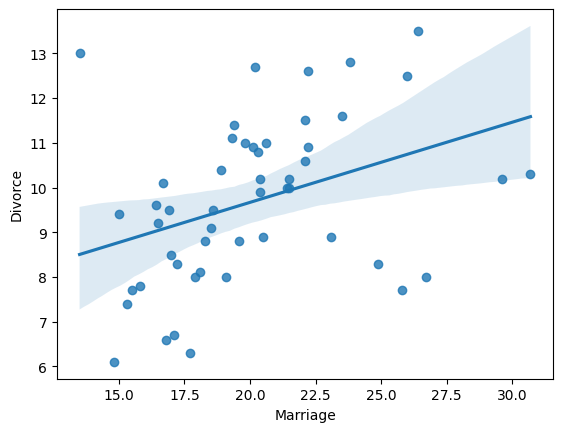

In [138]:
sns.regplot(df, x="Marriage", y="Divorce")

<Axes: xlabel='MedianAgeMarriage', ylabel='Divorce'>

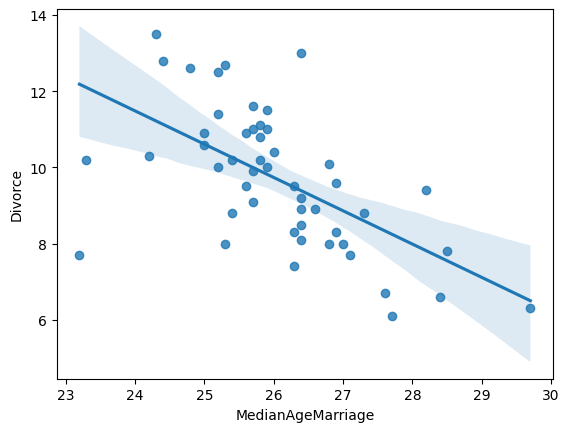

In [139]:
sns.regplot(df, x="MedianAgeMarriage", y="Divorce")

In [140]:
def standardize(x: pd.Series):
    return ((x - x.mean()) / x.std()).to_numpy()


# pipe trick for applying functions to a series
D = df["Divorce"].pipe(standardize)
M = df["Marriage"].pipe(standardize)
A = df["MedianAgeMarriage"].pipe(standardize)

prior predictive keys: dict_keys(['alpha', 'beta', 'mu', 'sigma', 'y'])


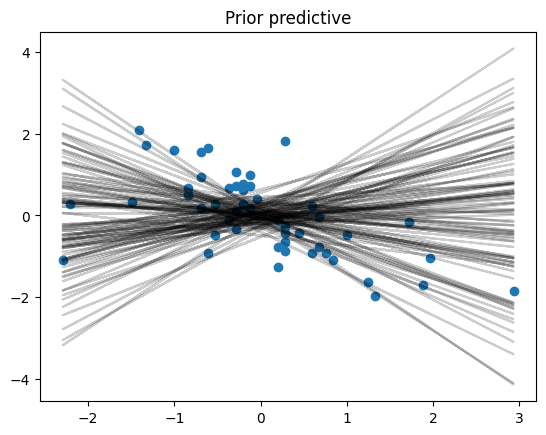

sample: 100%|██████████| 2100/2100 [00:00<00:00, 2637.54it/s, 3 steps of size 9.72e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.10     -0.00     -0.16      0.17   1497.15      1.00
      beta     -0.57      0.11     -0.56     -0.76     -0.39   2562.49      1.00
     sigma      0.83      0.09      0.82      0.69      0.96   1291.04      1.00

Number of divergences: 0
posterior predictive keys: dict_keys(['mu', 'y'])


In [146]:
# y can be non in case we want prior predictive samples
def m5_1(X, y=None):
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    beta = numpyro.sample("beta", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    # deterministic node to keep track of it when sampling, etc
    mu = numpyro.deterministic("mu", alpha + beta * X)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


# sample prior
num_samples = 100
prior_predictive = Predictive(m5_1, num_samples=num_samples)
prior_pred = prior_predictive(random.PRNGKey(0), X=A)
print("prior predictive keys:", prior_pred.keys())
plt.scatter(A, D)
for i in range(num_samples):
    plt.plot(A, prior_pred["mu"][i], c="black", alpha=0.2)
plt.title("Prior predictive")
plt.show()


# sample posterior
mcmc = MCMC(NUTS(m5_1), num_warmup=100, num_samples=2000)
mcmc.run(
    random.PRNGKey(0),
    X=A,
    y=D,
)
mcmc.print_summary()
posterior_m51 = mcmc.get_samples()

# get posterior predictive samples
predictive = Predictive(m5_1, posterior_m51)
posterior_predictive = predictive(random.PRNGKey(0), X=A)
print("posterior predictive keys:", posterior_predictive.keys())

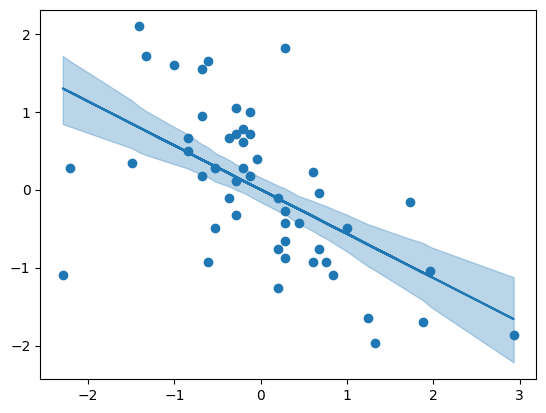

In [147]:
# or:  posterior["alpha"][:, None] + posterior["beta"][:, None] * A
# but we keep track of mu in the trace itself! convenient!
mu_hat = posterior_m51["mu"]
hdpi = numpyro.diagnostics.hpdi(mu_hat, prob=0.89, axis=0)

# plotting
plt.scatter(A, D)
plt.plot(A, np.mean(mu_hat, axis=0), c="C0")
sort_idx = jnp.argsort(A)
plt.fill_between(
    A[sort_idx], hdpi[0][sort_idx], hdpi[1][sort_idx], alpha=0.3, color="C0"
)

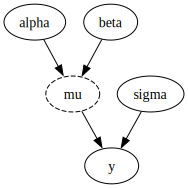

In [96]:
numpyro.render_model(m5_1, model_args=(A,))

sample: 100%|██████████| 2100/2100 [00:00<00:00, 2743.16it/s, 7 steps of size 7.12e-01. acc. prob=0.96]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.00      0.11      0.00     -0.17      0.21   1949.49      1.00
      beta      0.35      0.14      0.35      0.13      0.57   1770.44      1.00
     sigma      0.95      0.10      0.94      0.79      1.10   1615.02      1.00

Number of divergences: 0


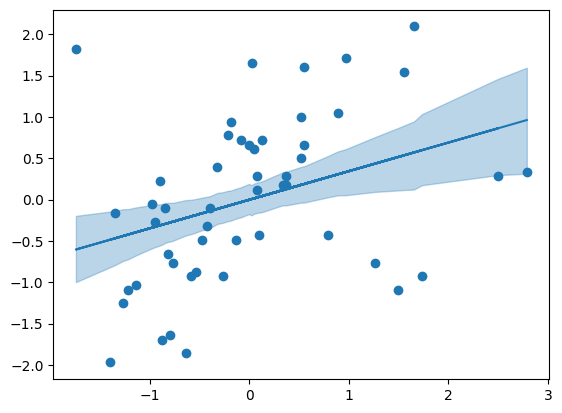

In [148]:
# y can be non in case we want prior predictive samples
def m5_2(X, y=None):
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    beta = numpyro.sample("beta", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    # deterministic node to keep track of it when sampling, etc
    mu = numpyro.deterministic("mu", alpha + beta * X)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


# sample posterior
mcmc = MCMC(NUTS(m5_1), num_warmup=100, num_samples=2000)
mcmc.run(
    random.PRNGKey(0),
    X=M,
    y=D,
)
mcmc.print_summary()
posterior_m52 = mcmc.get_samples()

mu_hat = posterior_m52["mu"]
hdpi = numpyro.diagnostics.hpdi(mu_hat, prob=0.89, axis=0)

# plotting
plt.scatter(M, D)
plt.plot(M, np.mean(mu_hat, axis=0), c="C0")
sort_idx = jnp.argsort(M)
plt.fill_between(
    M[sort_idx], hdpi[0][sort_idx], hdpi[1][sort_idx], alpha=0.3, color="C0"
)


DAGs : for thinking before modelling


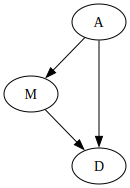

In [120]:
graphviz.Source("""digraph G{
nodesep=1
A -> {M D}
M -> D
}""")

the regression we did before : A vs D , represents the _total_ strength of the effect from A to D, that is, A->D as well as A->M->D.

Also, we know M and D is positively associated, but that isnt enough to say M-D is positive, because it could be the effect of A acting through M on D, not M on D alone.


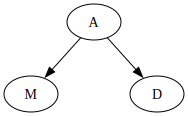

In [122]:
graphviz.Source("""digraph G{
nodesep=1
A -> {M D}
}""")

In this DAG, D is independant of M conditional on A - this means that when we learn all about A, M adds no extra information about D.

D \_||\_ M|A


this is a testable implication, and is the only difference between the first and second DAG. To test, we need a model that can condition on A, and see if that renders D independant of M. That's where multiple regression comes in.

REgression of D based on both A and M, can tell us what additional info A gives | M, and what additional infor M gives | A.

its purely descriptive, and the DAG + testable hypothesis give it any causal meaning


In [179]:
def m5_3(M=None, A=None, y=None):
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))

    # all data share the same params, so plate notation not needed
    mu = numpyro.deterministic("mu", alpha + bM * M + bA * A)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


mcmc = MCMC(NUTS(m5_3), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), M=M, A=A, y=D)
posterior_m53 = mcmc.get_samples()

sample: 100%|██████████| 2100/2100 [00:00<00:00, 2576.40it/s, 7 steps of size 9.63e-01. acc. prob=0.74]


In [150]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.10     -0.00     -0.16      0.16   2006.75      1.00
        bA     -0.61      0.16     -0.61     -0.87     -0.36   1070.80      1.00
        bM     -0.06      0.16     -0.06     -0.31      0.20   1186.82      1.00
     sigma      0.82      0.08      0.82      0.69      0.96   1793.17      1.00

Number of divergences: 0


array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'bA'}>,
       <Axes: title={'center': 'bM'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

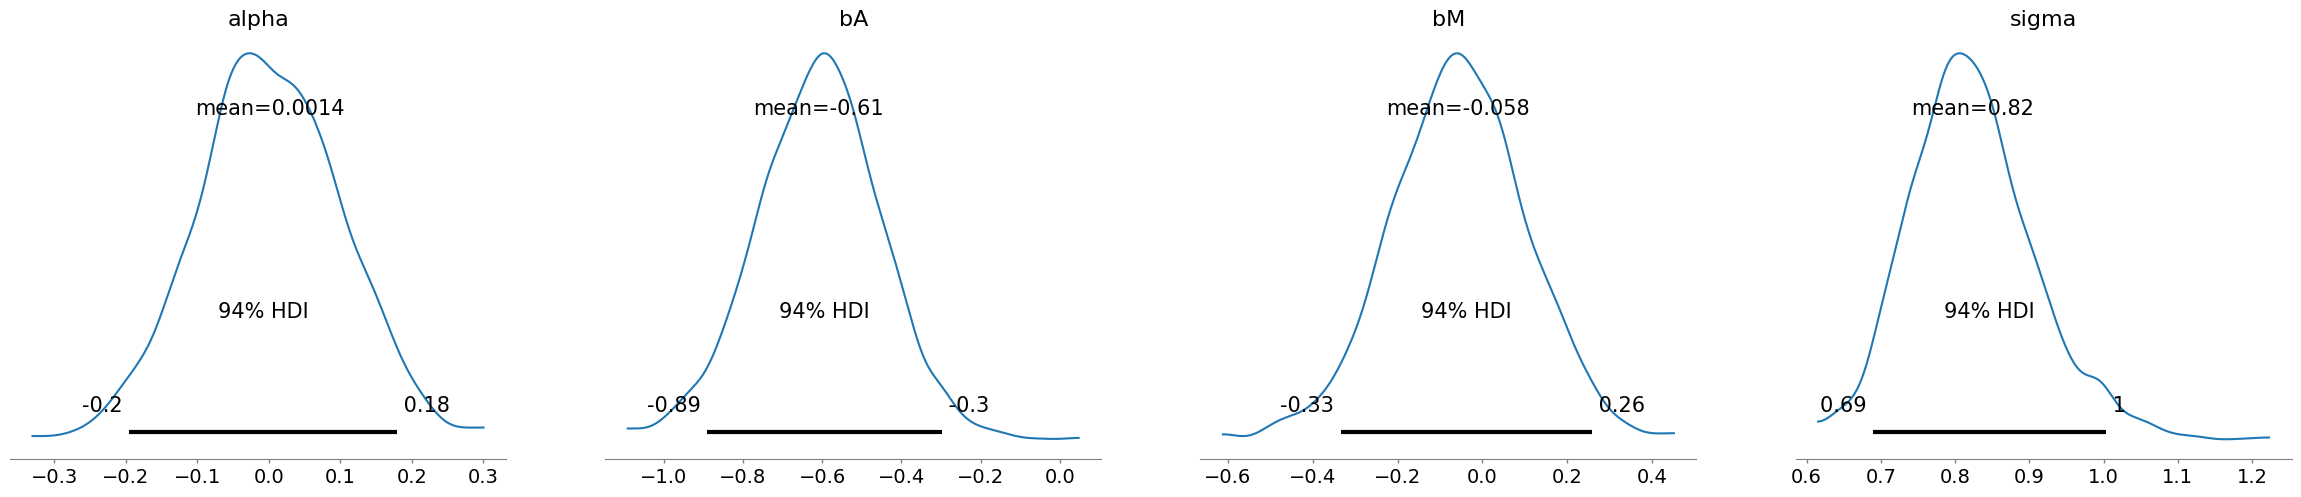

In [151]:
az.plot_posterior(az.from_numpyro(mcmc))

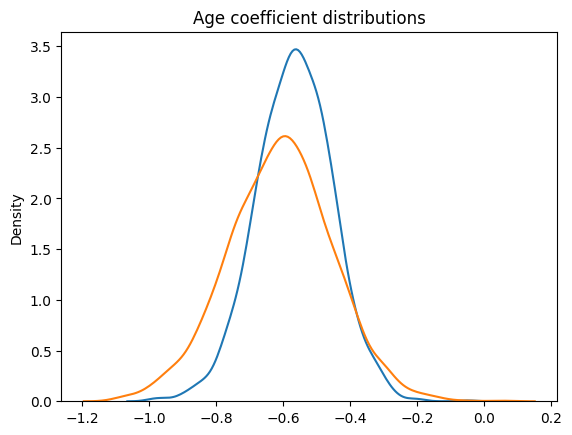

Text(0.5, 1.0, 'Marraige rate distributions')

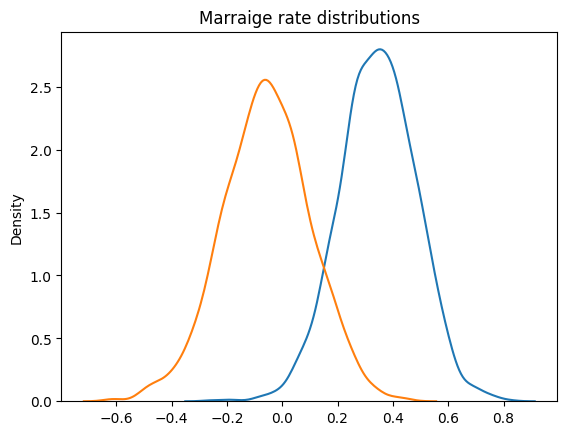

In [157]:
fig, ax = plt.subplots()
sns.kdeplot(posterior_m51["beta"], ax=ax)
sns.kdeplot(posterior_m53["bA"], ax=ax)
ax.set_title("Age coefficient distributions")
plt.show()

fig, ax = plt.subplots()
sns.kdeplot(posterior_m52["beta"], ax=ax)
sns.kdeplot(posterior_m53["bM"], ax=ax)
ax.set_title("Marraige rate distributions")


compare the individual linear fits slope coeffs with this multiple regression model. the marraige rate seems to have a weaker contribution in the multiple regression model (close to zero) in the prescense of age. this means that D\_||\_M|A.

> M is predictive but not causal


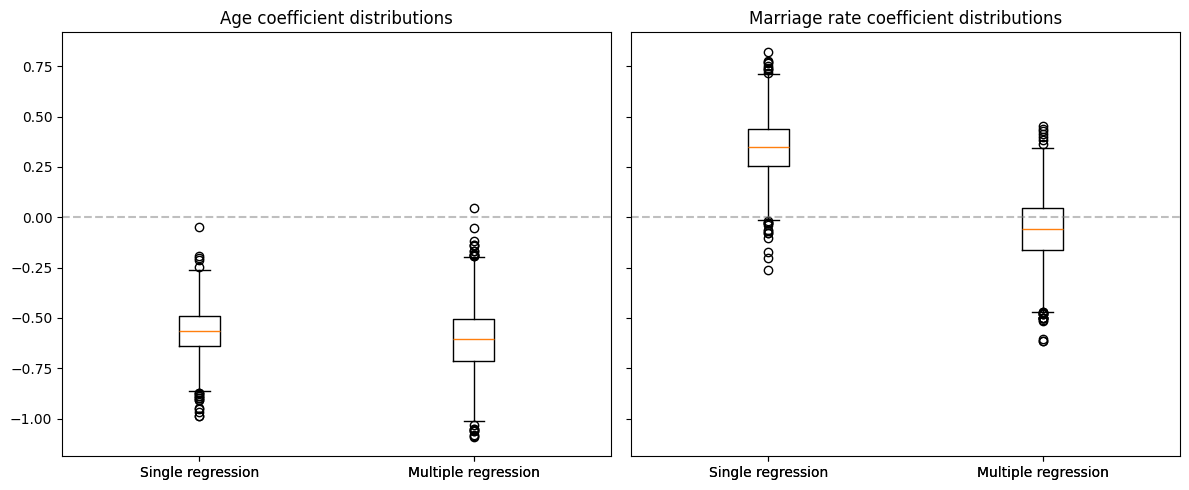

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

# Age coefficients
data_age = [posterior_m51["beta"], posterior_m53["bA"]]
ax[0].boxplot(data_age, labels=["Single regression", "Multiple regression"])
ax[0].set_title("Age coefficient distributions")

# Marriage rate coefficients
data_marriage = [posterior_m52["beta"], posterior_m53["bM"]]
ax[1].boxplot(data_marriage, labels=["Single regression", "Multiple regression"])
ax[1].set_title("Marriage rate coefficient distributions")

ax[0].axhline(y=0, color="gray", linestyle="--", alpha=0.5)
ax[1].axhline(y=0, color="gray", linestyle="--", alpha=0.5)


plt.tight_layout()
plt.show()


Let's now look at plotting multivariate posteriors! With single regression, we can scatter the data and plot a line. But for multivariate regression, there will be more plots involved.


In [168]:
def m5_4(X, y=None):
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bAM", dist.Normal(0, 0.5))

    mu = numpyro.deterministic("mu", alpha + bAM * X)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


mcmc = MCMC(NUTS(m5_4), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), X=A, y=D)
posterior_m54 = mcmc.get_samples()

sample: 100%|██████████| 2100/2100 [00:00<00:00, 2520.82it/s, 3 steps of size 8.45e-01. acc. prob=0.91]


<Axes: >

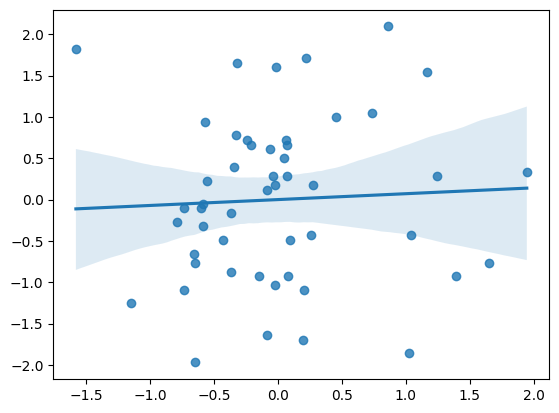

In [175]:
mu = posterior_m54["mu"].mean(axis=0)
# mu is the expected value of D vs A, so we are "removing the expected effect of A from M"
resid = M - mu

# not fitting a bayesian model here, but you get the point
sns.regplot(x=resid, y=D)

sample: 100%|██████████| 2100/2100 [00:01<00:00, 1689.77it/s, 3 steps of size 1.14e+00. acc. prob=0.89]


<Axes: >

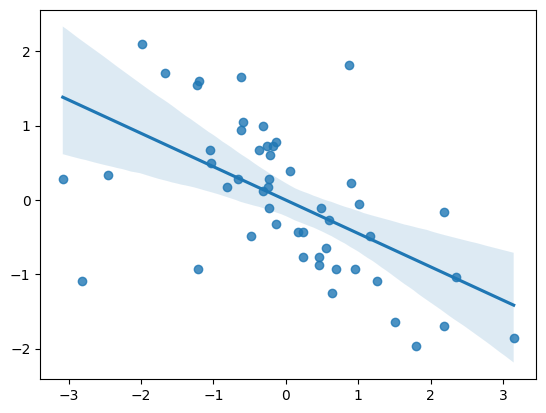

In [176]:
# same but with M - we see that A still has a negative influence even with M removed
mcmc = MCMC(NUTS(m5_4), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), X=M, y=D)
posterior_m54 = mcmc.get_samples()
mu = posterior_m54["mu"].mean(axis=0)
resid = A - mu
sns.regplot(x=resid, y=D)

These 'predictor residual plots' remove influence assuming the influence between two variables is additive, which might not always be the case. For that, we can see the posterior predictove plots.

Errors can be more easily diagnosed by comparing the predictive posterior with the raw data


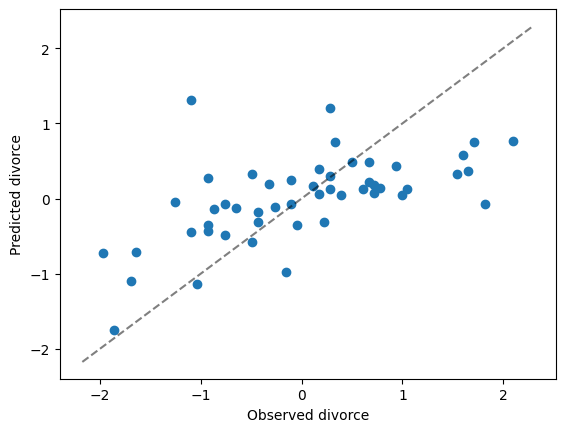

In [185]:
predictive = Predictive(m5_3, posterior_m53)
post_pred = predictive(random.PRNGKey(1), A=A, M=M, y=None)

mu = post_pred["mu"]
mu_mean = np.mean(mu, axis=0)

plt.scatter(D, mu_mean)
plt.xlabel("Observed divorce")
plt.ylabel("Predicted divorce")

# Add diagonal line for perfect prediction reference
lims = [
    min(plt.xlim()[0], plt.ylim()[0]),  # Get the minimum of both axes
    max(plt.xlim()[1], plt.ylim()[1]),  # Get the maximum of both axes
]
plt.plot(lims, lims, "k--", alpha=0.5)  # Plot diagonal line in black dashed style


if there was perfect agreement in the observed and predicted, we would see a perfect diagonal line. Divergence on the right side of zero means, it is under-predicting for high divorce rates, and divergence on the left side (things on top of the line) mean that the model is over-predicting for low rates of divorce. Thats fine - because thats what linear regression does, it is skeptical of extreme values.


Harsh but real truth - modelling only quantifies uncertainity in ways that the model understands the problem - answers to real world truth and causation depends on information not included in the model.

> A true hypothesis will both pass and fail tests on it's way to acceptance.


Now, lets look at another plot, the "counterfactual plot". The author uses it to refer to some computations we can do that go beyond the posterior distribution using the underlying causal model (that we made up). We can ask questions about either the past/future as well.


simplest: how would an outcome change if you change one variable at a time. To do that, vary just one variable, and _use the causal model_ to simulate other variables, including the outcome.


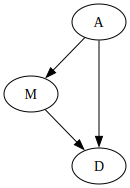

In [187]:
graphviz.Source("""digraph G{
nodesep=1
A -> {M D}
M -> D
}""")

In m5_3, we didn't need influence of A on M, because we were modeling total effect of A->D. But to predict consequences of manipulating A, we will need to have a model that models the affect A has on M, to predict the consequences of changing A


In [188]:
def m5_3A(M=None, A=None, y=None):
    # M -> D <- A
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", alpha + bM * M + bA * A)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)
    # A -> M
    alphaM = numpyro.sample("alphaM", dist.Normal(0, 0.2))
    bAM = numpyro.sample("bAM", dist.Normal(0, 0.5))
    sigmaM = numpyro.sample("sigmaM", dist.Exponential(1))
    muM = numpyro.deterministic("muM", alphaM + bAM * A)
    numpyro.sample("yM", dist.Normal(muM, sigmaM), obs=M)


mcmc = MCMC(NUTS(m5_3A), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), M=M, A=A, y=D)
mcmc.print_summary()

sample: 100%|██████████| 2100/2100 [00:01<00:00, 1946.23it/s, 7 steps of size 6.81e-01. acc. prob=0.88]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.10      0.00     -0.16      0.17   2853.09      1.00
    alphaM      0.00      0.09      0.00     -0.14      0.14   2809.10      1.00
        bA     -0.61      0.15     -0.61     -0.88     -0.37   1596.17      1.00
       bAM     -0.69      0.10     -0.69     -0.85     -0.52   3030.62      1.00
        bM     -0.06      0.15     -0.07     -0.30      0.20   1695.64      1.00
     sigma      0.83      0.09      0.82      0.68      0.96   2093.94      1.00
    sigmaM      0.71      0.08      0.71      0.59      0.83   2661.42      1.00

Number of divergences: 0


In [189]:
posterior = mcmc.get_samples()

In [203]:
# this is two sigma. mean is zero and std dev is 1 for A (normalising)
# so, -2 to 2 is two sigma
A_test = np.linspace(-2, 2, num=30)
M_sim = np.array(
    [
        np.random.normal(
            loc=posterior["alphaM"] + posterior["bAM"] * a,
            scale=posterior["sigmaM"],
        )
        for a in A_test
    ]
)

D_sim = np.array(
    [
        np.random.normal(
            loc=posterior["alpha"]
            + posterior["bA"] * A_test[i]
            + posterior["bM"] * M_sim[i],
            scale=posterior["sigma"],
        )
        for i in range(len(A_test))
    ]
)

D_sim.shape

(30, 2000)

(30, 2)


Text(0, 0.5, 'counterfactual D')

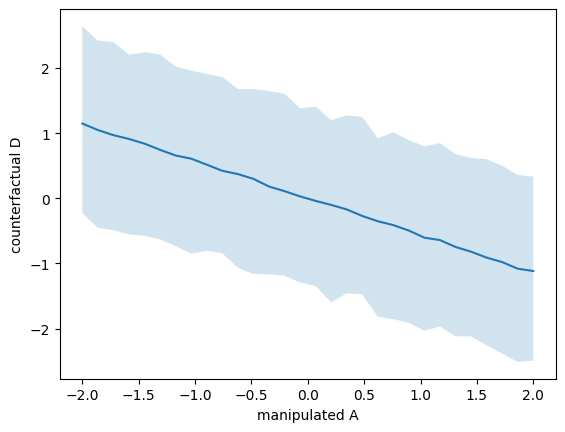

In [211]:
plt.plot(A_test, D_sim.mean(axis=1))
hpdi = numpyro.diagnostics.hpdi(D_sim, axis=1)
print(hpdi.shape)
plt.fill_between(A_test, hpdi[:, 0], hpdi[:, 1], alpha=0.2)


plt.xlabel("manipulated A")
# means, what would have happend to D if A was manipulated
plt.ylabel("counterfactual D")

the predicted trend in D above includes both A->D and A->M->D


Text(0, 0.5, 'counterfactual M')

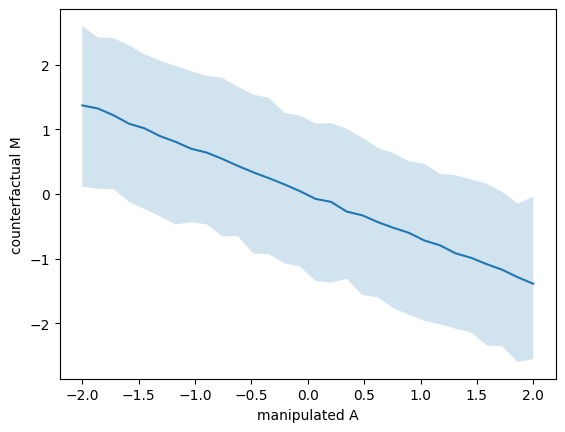

In [212]:
plt.plot(A_test, M_sim.mean(axis=1))
hpdi = numpyro.diagnostics.hpdi(M_sim, axis=1)
plt.fill_between(A_test, hpdi[:, 0], hpdi[:, 1], alpha=0.2)
plt.xlabel("manipulated A")
plt.ylabel("counterfactual M")

With counterfactuals, when you vary a variable, the causal influence of other variables on it ceases, since we are perfectly controlling it.

So if we vary M, all arrows leading to it are not it's causal factors anymore:


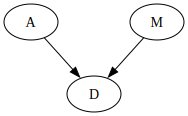

In [213]:
graphviz.Source("""digraph G{
nodesep=1
A -> D
M -> D
}""")

So, we dont need to simulate A's effect on M when exploring M's effect on D by varying it.


Text(0, 0.5, 'counterfactual D')

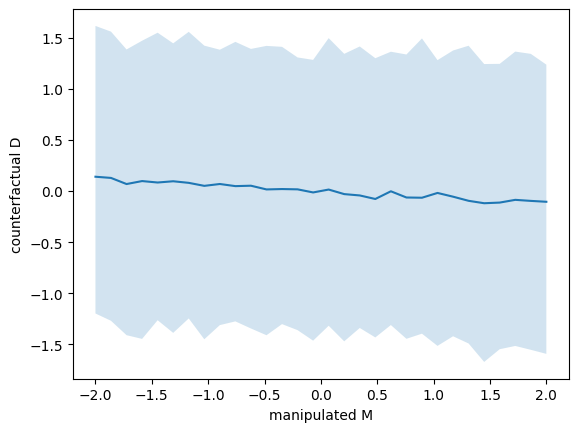

In [214]:
M_test = np.linspace(-2, 2, num=30)
# A takes an 'average state', is equal to zero.
D_sim = np.array(
    [
        np.random.normal(
            loc=posterior["alpha"] + posterior["bA"] * 0 + posterior["bM"] * M_test[i],
            scale=posterior["sigma"],
        )
        for i in range(len(M_test))
    ]
)
plt.plot(M_test, D_sim.mean(axis=1))
hpdi = numpyro.diagnostics.hpdi(D_sim, axis=1)
plt.fill_between(M_test, hpdi[:, 0], hpdi[:, 1], alpha=0.2)
plt.xlabel("manipulated M")
plt.ylabel("counterfactual D")

So, multiple predictor variables are helpful in knocking out spurious association.


## Masked relationship


This happens when two variables (used to predict the outcome) are correlated with each other, and additionally, one is positively correlated with the outcome and one is negatively correlated. So individually, they 'cancel' each other's effect, but the true effect is seen via multiple regression


In [223]:
df = pd.read_csv("./data/milk.csv", sep=";")
df = df[["kcal.per.g", "neocortex.perc", "mass"]]
df = df.dropna().reset_index(drop=True)
df

,kcal.per.g,neocortex.perc,mass
0,0.49,55.16,1.95
1,0.47,64.54,5.25
2,0.56,64.54,5.37
3,0.89,67.64,2.51
4,0.92,68.85,0.68
5,0.80,58.85,0.12
6,0.46,61.69,0.47
7,0.71,60.32,0.32
8,0.68,69.97,1.55
9,0.97,70.41,3.24


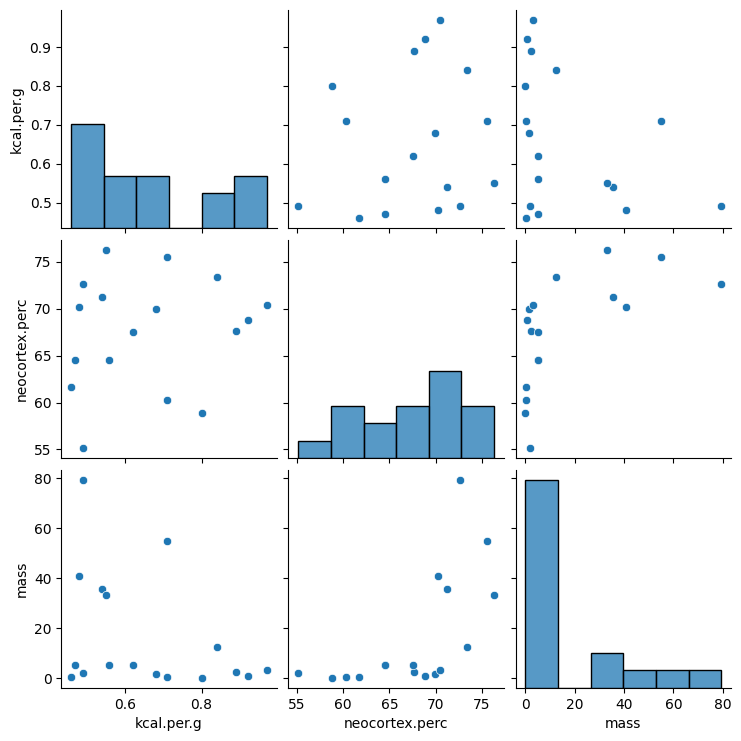

In [224]:
sns.pairplot(df)

In [226]:
def standardize(x: pd.Series):
    return ((x - x.mean()) / x.std()).to_numpy()


K = df["kcal.per.g"].pipe(standardize)
N = df["neocortex.perc"].pipe(standardize)
M = df["mass"].pipe(standardize)

prior predictive keys: dict_keys(['alpha', 'bN', 'mu', 'sigma', 'y'])


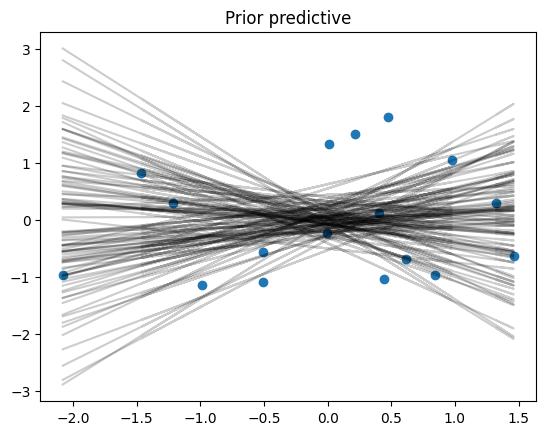

sample: 100%|██████████| 2100/2100 [00:00<00:00, 2579.41it/s, 3 steps of size 8.17e-01. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.15      0.00     -0.24      0.25   1720.76      1.00
        bN      0.12      0.24      0.12     -0.26      0.51   1751.95      1.00
     sigma      1.04      0.19      1.01      0.75      1.32   1270.90      1.00

Number of divergences: 0


In [237]:
def m5_5(X, y):
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", alpha + bN * X)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


num_samples = 100
prior_predictive = Predictive(m5_5, num_samples=num_samples)
prior_pred = prior_predictive(random.PRNGKey(0), X=N, y=K)
print("prior predictive keys:", prior_pred.keys())
plt.scatter(N, K)
for i in range(num_samples):
    plt.plot(N, prior_pred["mu"][i], c="black", alpha=0.2)
plt.title("Prior predictive")
plt.show()

mcmc = MCMC(NUTS(m5_5), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), X=N, y=K)
mcmc.print_summary()

Text(0.5, 1.0, 'Posterior predictive')

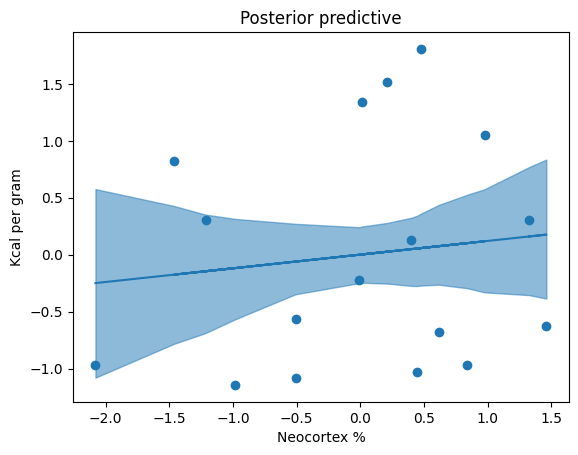

In [248]:
posterior_m55 = mcmc.get_samples()
mu = posterior_m55["mu"]
hpdi = numpyro.diagnostics.hpdi(mu)
plt.scatter(N, K)
plt.plot(N, np.mean(mu, axis=0))


s_idx = np.argsort(N)
plt.fill_between(N[s_idx], hpdi[0][s_idx], hpdi[1][s_idx], alpha=0.5, color="C0")
plt.xlabel("Neocortex %")
plt.ylabel("Kcal per gram")
plt.title("Posterior predictive")


sample: 100%|██████████| 2100/2100 [00:00<00:00, 2722.58it/s, 3 steps of size 1.03e+00. acc. prob=0.86]


Text(0.5, 1.0, 'Posterior predictive')

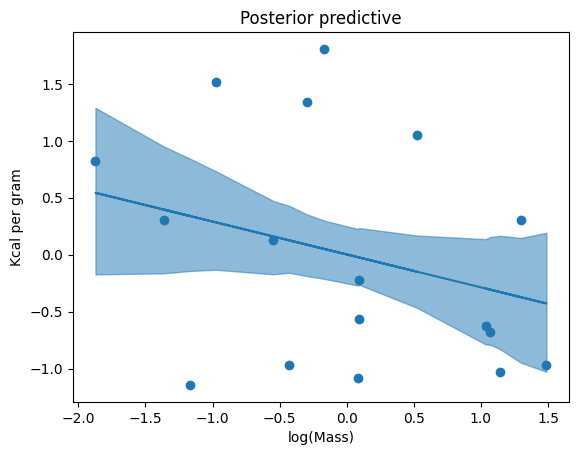

In [259]:
logM = np.log(df["mass"]).pipe(standardize)

mcmc = MCMC(NUTS(m5_5), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), X=logM, y=K)
posterior_m55 = mcmc.get_samples()
mu = posterior_m55["mu"]
hpdi = numpyro.diagnostics.hpdi(mu)
plt.scatter(logM, K)
plt.plot(logM, np.mean(mu, axis=0))
s_idx = np.argsort(M)
plt.fill_between(logM[s_idx], hpdi[0][s_idx], hpdi[1][s_idx], alpha=0.5, color="C0")
plt.xlabel("log(Mass)")
plt.ylabel("Kcal per gram")
plt.title("Posterior predictive")

In [262]:
def m5_6(X, y):
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", alpha + bM * X)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


mcmc = MCMC(NUTS(m5_6), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), X=N, y=K)
mcmc.print_summary()
posterior_m56 = mcmc.get_samples()


def m5_7(N, M, y):
    alpha = numpyro.sample("alpha", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bN = numpyro.sample("bN", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", alpha + bM * M + bN * N)
    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)


mcmc = MCMC(NUTS(m5_7), num_warmup=100, num_samples=2000)
mcmc.run(random.PRNGKey(0), N=N, M=M, y=K)
mcmc.print_summary()
posterior_m57 = mcmc.get_samples()

sample: 100%|██████████| 2100/2100 [00:01<00:00, 1588.34it/s, 3 steps of size 8.17e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.15      0.00     -0.24      0.25   1720.76      1.00
        bM      0.12      0.24      0.12     -0.26      0.51   1751.95      1.00
     sigma      1.04      0.19      1.01      0.75      1.32   1270.90      1.00

Number of divergences: 0


sample: 100%|██████████| 2100/2100 [00:01<00:00, 1874.37it/s, 7 steps of size 5.68e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.00      0.15      0.00     -0.25      0.23   1666.08      1.00
        bM     -0.50      0.24     -0.50     -0.94     -0.14   1243.89      1.00
        bN      0.38      0.24      0.39      0.00      0.79   1537.41      1.00
     sigma      0.90      0.18      0.88      0.64      1.16   1644.16      1.00

Number of divergences: 0


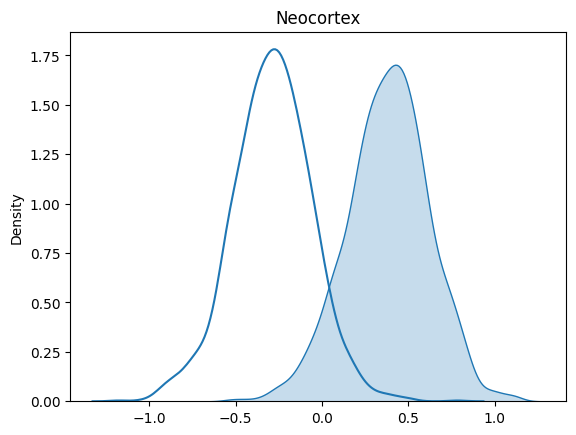

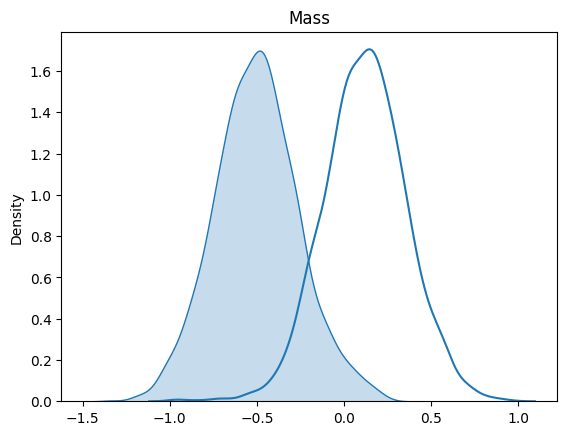

In [267]:
# filled ones are from multivariate regression
sns.kdeplot(posterior_m55["bN"])
sns.kdeplot(posterior_m57["bN"], fill=True)
plt.title("Neocortex")
plt.show()
sns.kdeplot(posterior_m56["bM"])
sns.kdeplot(posterior_m57["bM"], fill=True)
plt.title("Mass")
plt.show()

Neocortex (N) and mass (M) both had weaker relationships with the milk energy (K) individually, but their correlations become stronger when using multiple regression.

they 'masked' the influence of each other, since they are neg&pos correlated, but also correlated with each other.


we could make counterfactual plots here too, but i'm skipping it for now


## categorical variables

here, categorical is referring to a discreet and unordered category


In [269]:
df = pd.read_csv("./data/Howell1.csv", sep=";")
df

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


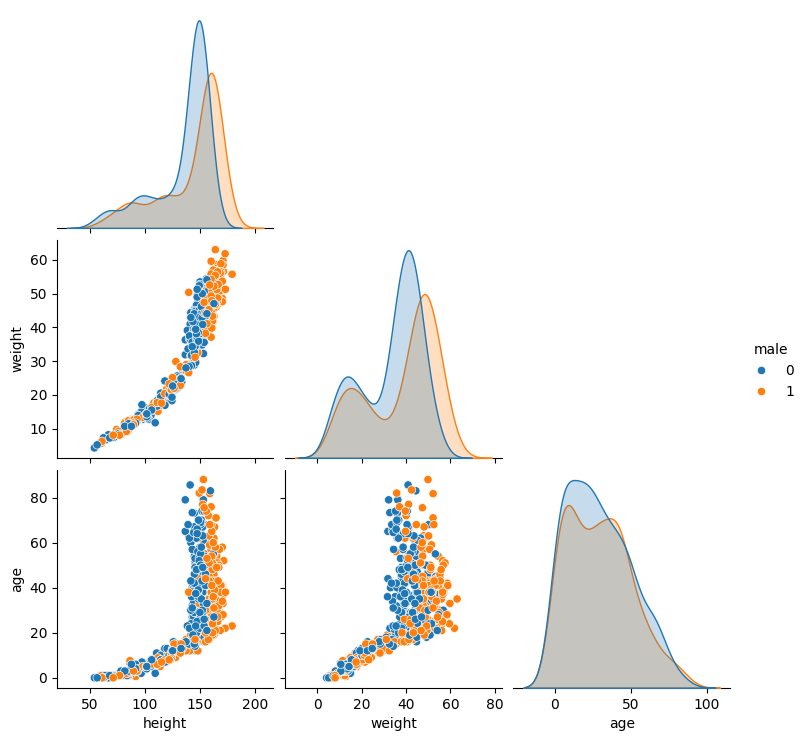

In [281]:
sns.pairplot(df, hue="male", corner=True)

In [283]:
def m5_8(sex=None, height=None):
    # different means but the same sigma.
    # Prior for each sex (index 0 and 1)
    a = numpyro.sample("a", dist.Normal(178, 20).expand([2]))  # [2] for two sexes
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))

    # Use sex as index to select the right mean
    mu = a[sex]  # sex should be array of 0s and 1s

    # Likelihood
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


# When calling the model:
mcmc = MCMC(NUTS(m5_8), num_warmup=100, num_samples=2000)
mcmc.run(
    random.PRNGKey(0),
    sex=df["male"].values,  # Pass array of 0s and 1s
    height=df["height"].values,
)
posterior_m58 = mcmc.get_samples()

sample: 100%|██████████| 2100/2100 [00:01<00:00, 1585.25it/s, 15 steps of size 2.31e-02. acc. prob=0.96]


In [284]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]    134.92      1.63    134.92    132.43    137.65   1072.46      1.00
      a[1]    142.66      1.79    142.60    139.60    145.30    722.03      1.00
     sigma     27.43      0.82     27.41     26.04     28.74   2251.57      1.00

Number of divergences: 0


In [287]:
posterior_m58["a"].shape

(2000, 2)

a is interpreted as the expected height in female(a[0]) and male (a[1]) respectively


<Axes: ylabel='Density'>

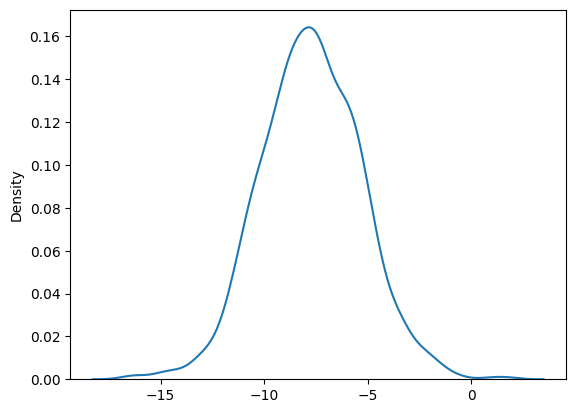

In [289]:
# expected difference in height in female and male:
sns.kdeplot(posterior_m58["a"][:, 0] - posterior_m58["a"][:, 1])

let's return to the primate example, to look at multiple categories


In [293]:
df = pd.read_csv("./data/milk.csv", sep=";")
# df = df[["kcal.per.g", "neocortex.perc", "mass"]]
# df = df.dropna().reset_index(drop=True)
df

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


In [304]:
def m5_9(index=None, y=None):
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(np.unique(index))]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[index]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=y)


mcmc = MCMC(NUTS(m5_9), num_warmup=100, num_samples=2000)
mcmc.run(
    random.PRNGKey(0),
    index=df["clade"].factorize()[0],
    y=df["kcal.per.g"].pipe(standardize),
)
posterior_m59 = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 2100/2100 [00:00<00:00, 2601.32it/s, 7 steps of size 6.11e-01. acc. prob=0.94]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      a[0]     -0.56      0.29     -0.56     -1.06     -0.10   2433.25      1.00
      a[1]      0.35      0.23      0.35     -0.03      0.71   2942.86      1.00
      a[2]      0.64      0.28      0.64      0.19      1.08   2392.16      1.00
      a[3]     -0.47      0.23     -0.47     -0.82     -0.09   2914.76      1.00
     sigma      0.80      0.12      0.78      0.60      0.97   2501.43      1.00

Number of divergences: 0


you have to compute the distribution of the difference (if thats what you want), this is called a contrast. you cant just eyeball it


the defining question of multiple regression - what is the value of knowing a predictor, given we know the other predictors?


# Summary so far

Bit of a dry chapter, and i want to write down a summary for the sake of my understanding, instead of doing all the homework problems, which i think might be an ideal use of my time.

This chapter is mainly about how multiple regression can help us deal with confounds - which are variables that hide/inflate the effect of other variables. But you cant just chuck things into multiple linear regression - you need to have a DAG for 'causal inference' (it is normal that the causal model will have unverifiable assumptions, but that does not mean you cant do useful things and test stuff with it). The chapter then discusses construction of DAGs, what they imply (eg: given A, is B and C independant? since it is given A, this is a conditional independance. Things like this, which the DAG implies), then various plots for multivariate posteriors, such as predictor residual plots, posterior prediction plots, and counterfactual plots. The chapter also discusses a masked relationship - where variables can individually seem less important when their influence is seen on the final estimand - but when taken together, via multiple linear regression for example, they can both have an increased effect (this can happen for example, if the two variables themselves are negatively correlated). Finally, we look at how categorical variables are handled. To deal with them, ie, to include a categorical variable difference in the model, we use an index variable to index into an array of parameters, one which corresponds to each category. For example, you could have a different mu for each category.


# Homework


e1: 2, 4 are multiple linear regression, as there are multiple coefficients as well as multiple variables.

e2: `animaldiversity = alpha + b1*latitude + b2*plantdiversity`

> write actual bayesian model, with normal dist, sigma, etc.

e3: `timetodegree = alpha + b1*funding + b2*labsize`. maybe b1 is positive and b2 is negative, since bigger lab means lesser attention from supervisor?

> both can have positive slopes but not seen individually, if they have a negative correlation with each other. eg: bigger lab = smaller funding per student = longer degree; or small lab = more funding per student but lesser intellectual environment = longer degree

e4: 2,4 are equal maybe.

> 1,3,4,5 are interentially equal. in model 1 for example, alpha will be the parameter corresponding to C. The other coefficients will be the difference from C (C is 'baseline') since they will be alpha+something. Pay attention, tht A,B,C,D are all indicator variables, and a data point can only be one of them at a time! then the answer will make sense.
